In [1]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.layers import Flatten, Conv2D, MaxPooling2D

Google Drive 에서 데이터 파일 마운트 하려면 다음과 같이 하면되지만, 프로그래밍 편의를 위해 wget 으로 직접 다운로드 함

from google.colab import drive   

drive.mount('/content/gdrive/')  

import shutil

shutil.copy('/content/gdrive/My Drive/Colab Notebooks/dataset/GTSRB_Final_Training_Images.zip', '/content/')

In [2]:
# 파일 다운로드

!wget https://sid.erda.dk/public/archives/daaeac0d7ce1152aea9b61d9f1e19370/GTSRB_Final_Training_Images.zip

--2022-02-01 09:26:16--  https://sid.erda.dk/public/archives/daaeac0d7ce1152aea9b61d9f1e19370/GTSRB_Final_Training_Images.zip
Resolving sid.erda.dk (sid.erda.dk)... 130.225.104.13
Connecting to sid.erda.dk (sid.erda.dk)|130.225.104.13|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 276294756 (263M) [application/zip]
Saving to: ‘GTSRB_Final_Training_Images.zip’

GTSRB_Final_Trainin 100%[===================>] 263.50M  23.4MB/s    in 12s     

2022-02-01 09:26:29 (21.9 MB/s) - ‘GTSRB_Final_Training_Images.zip’ saved [276294756/276294756]



# 디렉토리 설정

In [3]:
import os

ROOT_DIR = '/content'

DATA_ROOT_DIR = os.path.join(ROOT_DIR, 'GTSRB/Final_Training/Images/')

In [4]:
import os
import shutil

if os.path.exists('/content/GTSRB/'):    # 작업 디렉토리는 GTSRB
    
    shutil.rmtree('/content/GTSRB/')
    print('/content/GTSRB/  is removed !!!')

In [5]:
# 압축파일 풀기

import zipfile

with zipfile.ZipFile('/content/GTSRB_Final_Training_Images.zip', 'r') as target_file:
    
    target_file.extractall()

압축을 풀어보면, 데이터 디렉토리 구조는 다음과 같음

GTSRB
 |- Final_Training
    |- Images
        |- 00000
        |- 00001
        |- 00002
        |- .....
        |- 00042

In [6]:
# 데이터 전체 개수 확인

import os
import glob

# 데이터 정답 (label) 개수 및 종류 확인

label_name_list = os.listdir(DATA_ROOT_DIR)

print('total label nums = ', len(label_name_list))
print('=================================================')
print(label_name_list)

total label nums =  43
['00034', '00002', '00016', '00040', '00021', '00022', '00023', '00004', '00014', '00027', '00018', '00019', '00005', '00020', '00029', '00013', '00041', '00015', '00032', '00000', '00008', '00030', '00007', '00006', '00026', '00024', '00003', '00031', '00038', '00017', '00009', '00036', '00035', '00011', '00033', '00025', '00037', '00039', '00012', '00028', '00010', '00042', '00001']


원본 image를 정답 디렉토리 별로 읽어서 x_train numpy 생성 
train label 읽어서 y_train numpy 생성

In [7]:
import os
import cv2
import glob
import numpy as np
from datetime import datetime

image_list = []
label_list = []

image_label_list = os.listdir(DATA_ROOT_DIR)    # 정답이름

for label_name in image_label_list:

    # 이미지 파일 읽어오기

    file_path = os.path.join(DATA_ROOT_DIR, label_name)
    img_file_list = glob.glob(file_path+'/*.ppm')

    # 각각의 정답 디렉토리에 있는 이미지 파일, 즉 .ppm 파일 읽어서 리스트에 저장
    
    for img_file in img_file_list:

        try:
            src_img = cv2.imread(img_file, cv2.IMREAD_COLOR) 
            src_img = cv2.resize(src_img, dsize=(32,32))
            src_img = cv2.cvtColor(src_img, cv2.COLOR_BGR2RGB)

            image_list.append(src_img)
            label_list.append(float(label_name))  # 정답은 문자열을 실수로 변환

        except Exception as err:
            print(str(err), img_file)
            continue

In [8]:
# numpy 변환

x_train = np.array(image_list).astype('float32')
y_train = np.array(label_list).astype('float32')

print('x_train.shape = ', x_train.shape, ', y_train.shape = ', y_train.shape)

x_train.shape =  (39209, 32, 32, 3) , y_train.shape =  (39209,)


test data 생성. train : test = 8 : 2 

단, 데이터 다양성을 위해서 train data 를 먼저 random shuffle 한후에 test data 생성함. 이때 주의할것은 label data 도 동일한 인덱스로 shuffle 되어야 한다는 것이다 

In [9]:
import numpy as np

s = np.arange(len(x_train))  # [ 0 1 2...39206 39207 39208]

np.random.shuffle(s)         # index random shuffle

x_train = x_train[s]
y_train = y_train[s]

x_train : x_test = 8 : 2

In [10]:
SPLIT_RATIO = 0.2    # 20%

SPLIT_NUMS = int(SPLIT_RATIO*len(x_train))

x_test = x_train[0:SPLIT_NUMS]
y_test = y_train[0:SPLIT_NUMS]

x_train = x_train[SPLIT_NUMS:]
y_train = y_train[SPLIT_NUMS:]

x_train, x_test, y_train, y_test shape 확인

In [11]:
print('x_train.shape = ', x_train.shape, ', y_train.shape = ', y_train.shape)
print('x_test.shape = ', x_test.shape, ', y_test.shape = ', y_test.shape)

x_train.shape =  (31368, 32, 32, 3) , y_train.shape =  (31368,)
x_test.shape =  (7841, 32, 32, 3) , y_test.shape =  (7841,)


In [12]:
print(y_train[:3])
print(y_test[:3])

[ 9. 18.  3.]
[41. 12. 18.]


데이터 정규화

In [13]:
# 정규화 

x_train = x_train.astype(np.float32) / 255.0
x_test = x_test.astype(np.float32) / 255.0

이미지 출력

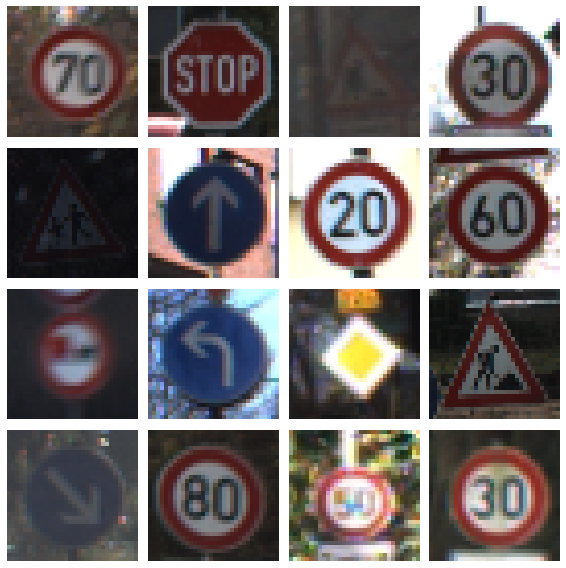

In [14]:
import matplotlib.pyplot as plt

random_index = np.random.randint(0, len(x_train), 16)    # 16개 랜덤 train 데이터 추출 

plt.figure(figsize=(8,8))

for pos in range(len(random_index)):

    plt.subplot(4,4,pos+1)
    plt.axis('off')
    train_img_index = random_index[pos]
    plt.imshow(x_train[train_img_index])

plt.tight_layout()
plt.show()

Sequential 모델 구축

In [22]:
n_classes = len(os.listdir(DATA_ROOT_DIR))  # 정답 개수

model = Sequential()

model.add(Conv2D(input_shape=(32,32,3), kernel_size=(3,3), filters=32, activation='relu'))
model.add(Conv2D(kernel_size=(3,3), filters=64, activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Flatten())

model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(n_classes, activation='softmax'))

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 30, 30, 32)        896       
                                                                 
 conv2d_3 (Conv2D)           (None, 28, 28, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 14, 14, 64)       0         
 2D)                                                             
                                                                 
 dropout_2 (Dropout)         (None, 14, 14, 64)        0         
                                                                 
 flatten_1 (Flatten)         (None, 12544)             0         
                                                                 
 dense_2 (Dense)             (None, 256)               3211520   
                                                      

In [23]:
model.compile(loss='sparse_categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adam(), metrics=['accuracy'])

In [24]:
from tensorflow.keras.callbacks import EarlyStopping
from datetime import datetime

earlystopping = EarlyStopping(monitor='val_loss', patience=5, verbose=1)   

start_time = datetime.now()

hist = model.fit(x_train, y_train, batch_size=32, epochs=30, 
                 validation_data=(x_test, y_test), callbacks=[earlystopping])

end_time = datetime.now()

print('elapsed time => ', end_time-start_time)

Epoch 1/30
981/981 [==============================] - 13s 13ms/step - loss: 0.9402 - accuracy: 0.7401 - val_loss: 0.1466 - val_accuracy: 0.9651
Epoch 2/30
981/981 [==============================] - 12s 12ms/step - loss: 0.2071 - accuracy: 0.9398 - val_loss: 0.0740 - val_accuracy: 0.9856
Epoch 3/30
981/981 [==============================] - 12s 12ms/step - loss: 0.1192 - accuracy: 0.9635 - val_loss: 0.0545 - val_accuracy: 0.9884
Epoch 4/30
981/981 [==============================] - 12s 12ms/step - loss: 0.0867 - accuracy: 0.9734 - val_loss: 0.0488 - val_accuracy: 0.9893
Epoch 5/30
981/981 [==============================] - 12s 12ms/step - loss: 0.0663 - accuracy: 0.9796 - val_loss: 0.0416 - val_accuracy: 0.9916
Epoch 6/30
981/981 [==============================] - 12s 12ms/step - loss: 0.0552 - accuracy: 0.9827 - val_loss: 0.0417 - val_accuracy: 0.9912
Epoch 7/30
981/981 [==============================] - 12s 12ms/step - loss: 0.0486 - accuracy: 0.9844 - val_loss: 0.0332 - val_accuracy:

In [25]:
model.evaluate(x_test, y_test)

246/246 [==============================] - 1s 5ms/step - loss: 0.0338 - accuracy: 0.9936


[0.033778876066207886, 0.9936232566833496]

In [26]:
y_pred = model.predict(x_test)

print(y_pred.shape)

(7841, 43)


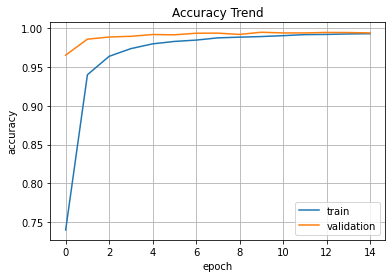

In [27]:
import matplotlib.pyplot as plt

plt.plot(hist.history['accuracy'], label='train')
plt.plot(hist.history['val_accuracy'], label='validation')
plt.title('Accuracy Trend')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(loc='best')
plt.grid()
plt.show()

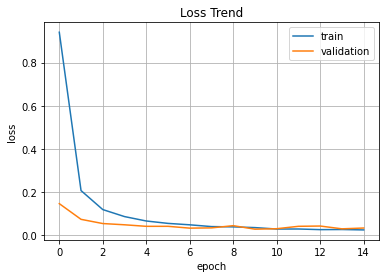

In [28]:
plt.plot(hist.history['loss'], label='train')
plt.plot(hist.history['val_loss'], label='validation')
plt.title('Loss Trend')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(loc='best')
plt.grid()
plt.show()